<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h3><center>Clément VERON | Thomas Bodart | Marc Garcia</center></h3>
<h1>
<hr style=" border:none; height:3px;">
<center>Graph mining project</center>
<hr style=" border:none; height:3px;">
</h1>


# 0- Installation des packages

In [ ]:
# ! pip install networkx
# ! pip install matplotlib
# ! pip install scipy
# ! pip install gensim
# ! pip install node2vec
# ! pip install scikit-learn
# ! pip install numpy 
# ! pip install tqdm
# ! pip install seaborn
! pip install random
! pip install collections

# 1- Chargement des données

In [1]:
import os
from pathlib import Path
import networkx as nx

file_dir = Path(os.getcwd()) 
lastfm_data_path = file_dir / "lastfm_asia"
deezer_data_path = file_dir / "deezer_europe"

assert os.path.isdir(
    deezer_data_path
), f"Deezer data path is missing: {deezer_data_path}"
assert os.path.isdir(
    lastfm_data_path
), f"LastFM data path is missing: {lastfm_data_path}"

lastfm_edges_path = lastfm_data_path / "lastfm_asia_edges.csv"
deezer_edges_path = deezer_data_path / "deezer_europe_edges.csv"

assert os.path.exists(
    deezer_edges_path
), f"Deezer edges file is missing: {deezer_edges_path}"
assert os.path.exists(
    lastfm_edges_path
), f"LastFM edges file is missing: {lastfm_edges_path}"


def read_edges(file_path):
    edges = []
    with open(file_path, "r") as file:
        next(file)
        for line in file:
            source, target = line.strip().split(",")
            edges.append((int(source), int(target)))
    return edges


lastfm_edges = read_edges(lastfm_edges_path)
deezer_edges = read_edges(deezer_edges_path)

deezer_graph = nx.from_edgelist(deezer_edges)
lastfm_graph = nx.from_edgelist(lastfm_edges)

print("Deezer graph : ", deezer_graph)
print("Lastfm graph : ", lastfm_graph)

Deezer graph :  Graph with 28281 nodes and 92752 edges
Lastfm graph :  Graph with 7624 nodes and 27806 edges


# 2- Centralités

In [4]:
def compute_all_centralities(graph):
    centralities = {}

    # Calcul de l'ensemble des centralités
    degree_centrality = nx.degree_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=100, tol=1e-05)
    katz_centrality = nx.katz_centrality(graph, alpha=0.02, beta=1.0, max_iter=1000, tol=1e-05)
    pagerank_centrality = nx.pagerank(graph)
    clustering_centrality = nx.clustering(graph)
    neighborhood_connectivity = nx.average_neighbor_degree(graph)

    # Création d'un dictionnaire des centralités
    centrality_measures = {
        "degree": degree_centrality,
        "eigenvector": eigenvector_centrality,
        "katz": katz_centrality,
        "pagerank": pagerank_centrality,
        "clustering": clustering_centrality,
        "neighborhood": neighborhood_connectivity
    }

    for node in graph.nodes():
        centralities[node] = {}

    # Calcul des rankings pour l'ensemble des centralités
    for centrality_type, values in centrality_measures.items():
        sorted_nodes = sorted(values, key=values.get, reverse=True) 
        ranking = {node: rank + 1 for rank, node in enumerate(sorted_nodes)} 
        
        # Ajout des valeurs et du rang de chaque noeud pour toutes les centralités
        for node in graph.nodes():
            centralities[node][centrality_type] = {
                "rank": ranking[node],
                "value": values[node]
            }
    
    return centralities

deezer_centralities = compute_all_centralities(deezer_graph)
lastfm_centralities = compute_all_centralities(lastfm_graph)

## 2.1 - Deezer Europe Centralities

c:\Users\clemv\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


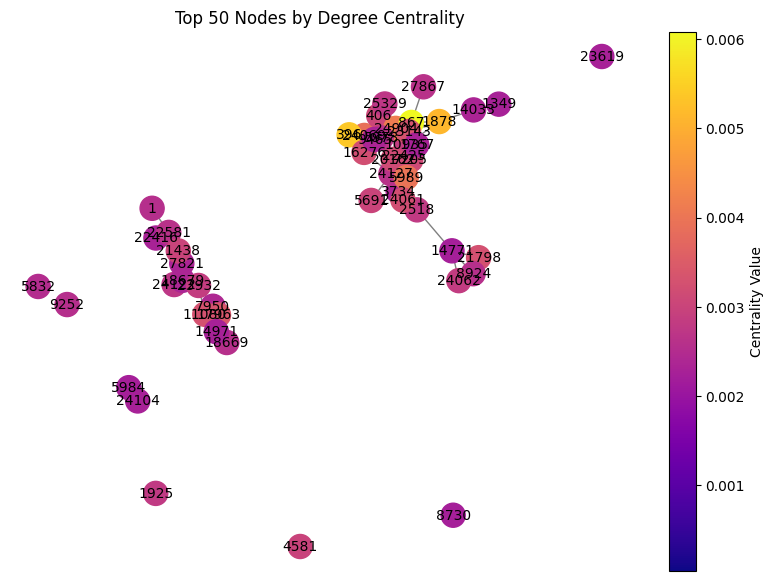

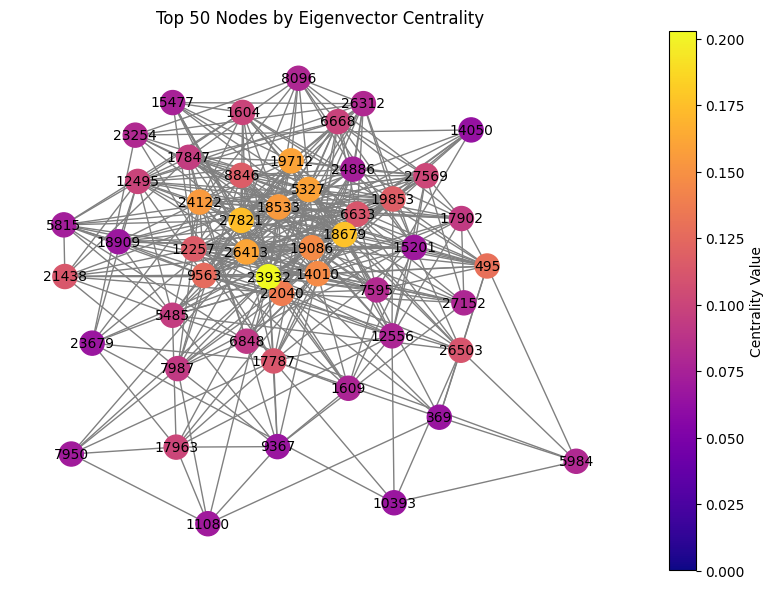

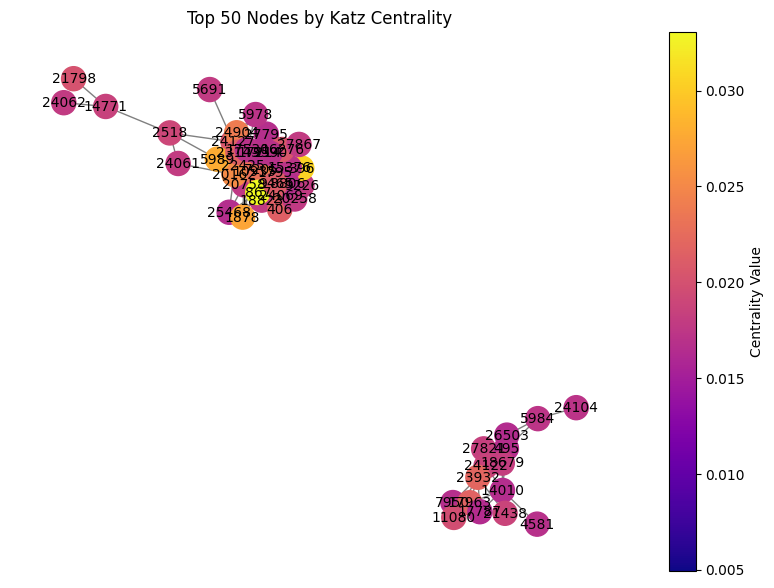

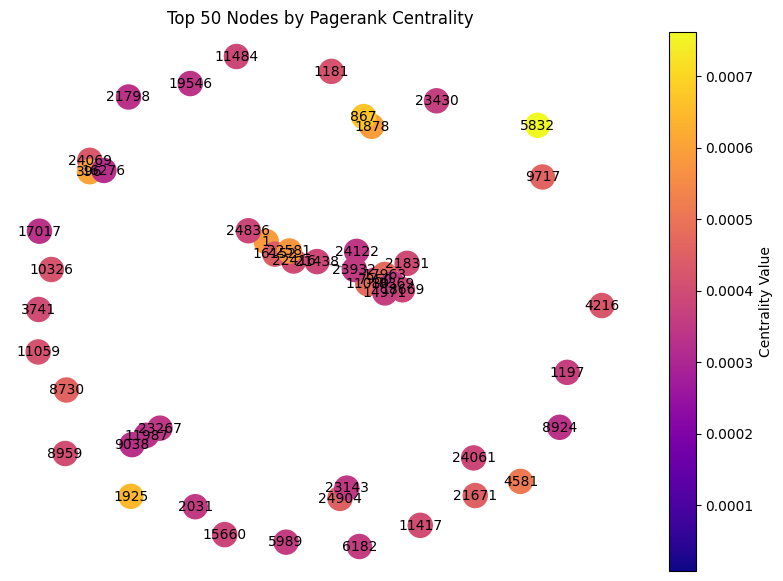

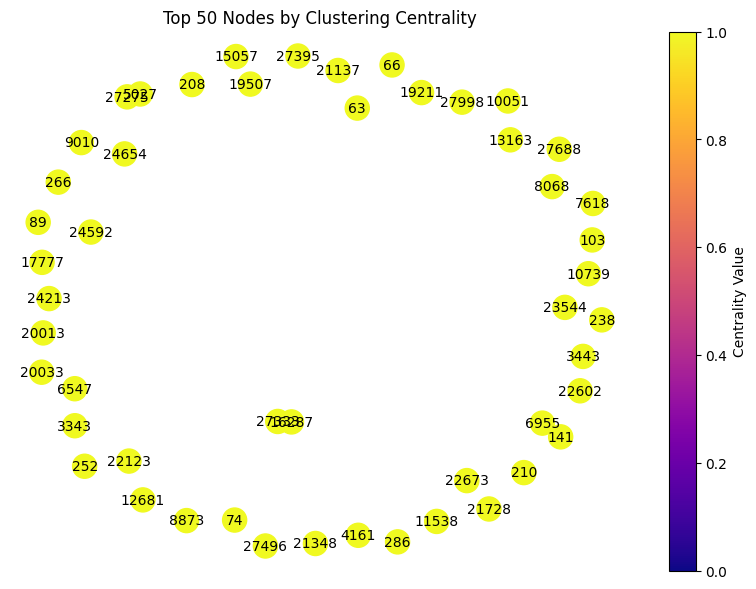

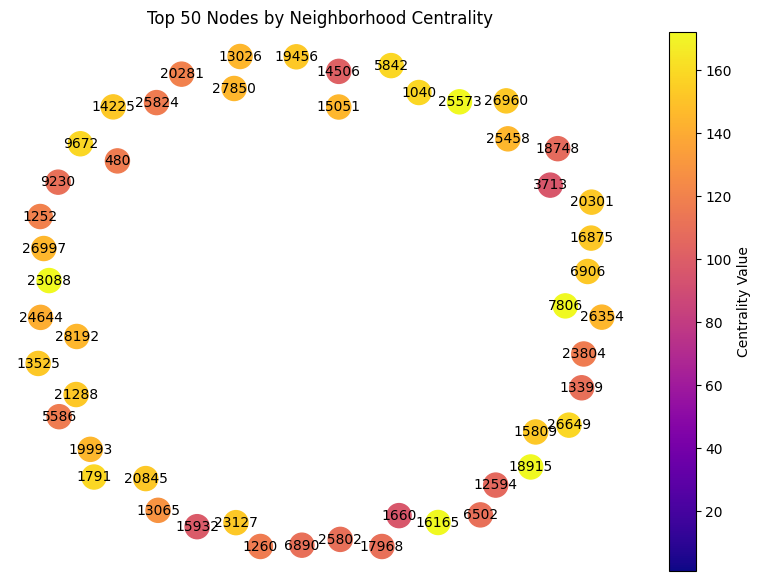

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def extract_top_subgraph(graph, centrality_dict, centrality_type, top_n=50):
    """Extracts a subgraph with the top N nodes based on a chosen centrality measure."""
    centrality_values = {node: data[centrality_type]["value"] for node, data in centrality_dict.items()}
    top_nodes = sorted(centrality_values, key=centrality_values.get, reverse=True)[:top_n]
    return graph.subgraph(top_nodes), centrality_values

def visualize_graph(graph, centrality_values, title="Graph Visualization"):
    """Visualizes the graph with node color and size based on a chosen centrality measure."""
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    # Mapping des centralités avec des couleurs
    centrality_array = np.array(list(centrality_values.values()))
    norm = plt.Normalize(vmin=centrality_array.min(), vmax=centrality_array.max())
    cmap = plt.cm.plasma 
    node_colors = [cmap(norm(centrality_values[node])) for node in graph.nodes()]

    pos = nx.spring_layout(graph, seed=42)

    nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color="gray",
            font_size=10, cmap=cmap, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    plt.colorbar(sm, ax=ax, label="Centrality Value")

    plt.title(title)
    plt.show()


# Select centrality type for visualization
chosen_centralities = ["degree", "eigenvector", "katz", "pagerank", "clustering", "neighborhood"]

for chosen_centrality in chosen_centralities:
    subgraph, subgraph_centrality_values = extract_top_subgraph(deezer_graph, deezer_centralities, chosen_centrality)
    visualize_graph(subgraph, subgraph_centrality_values, title=f"Top 50 Nodes by {chosen_centrality.capitalize()} Centrality")



## 2.2 - Lastfm Graph Centralities

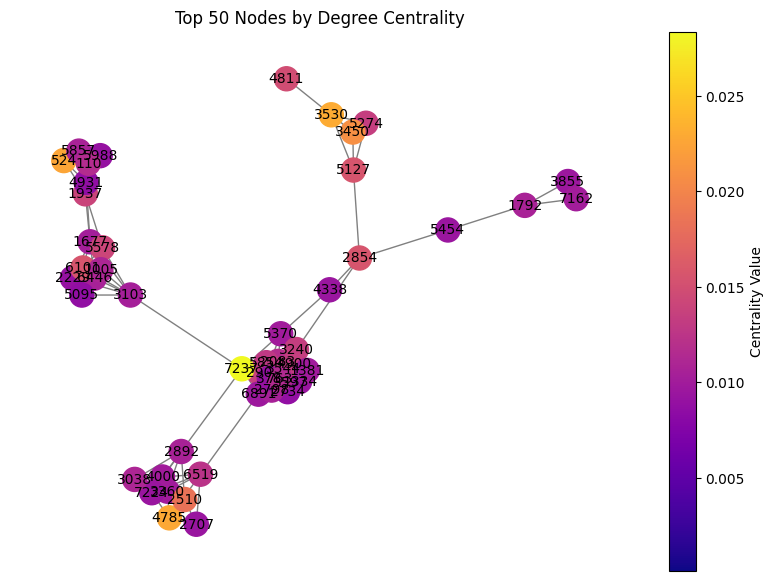

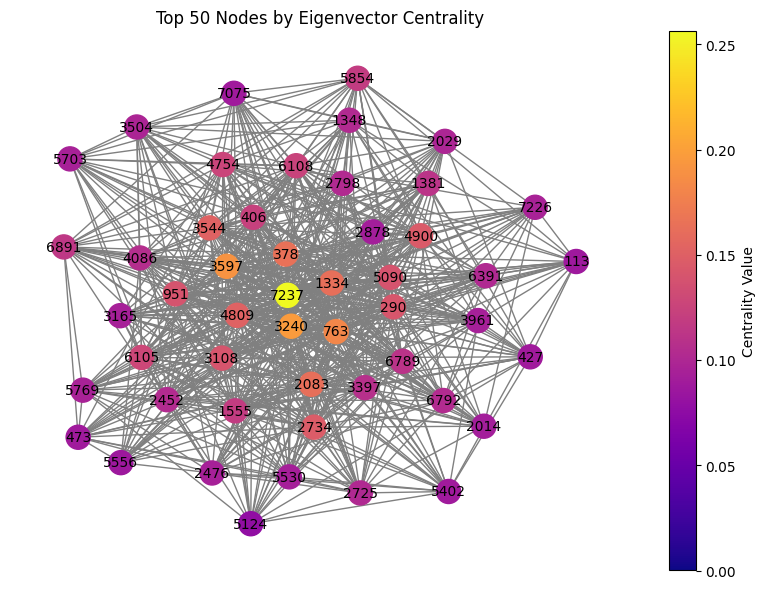

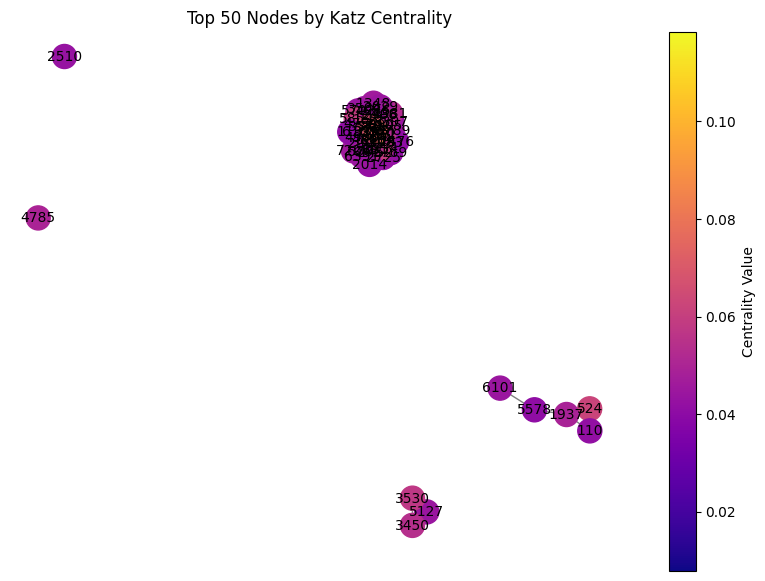

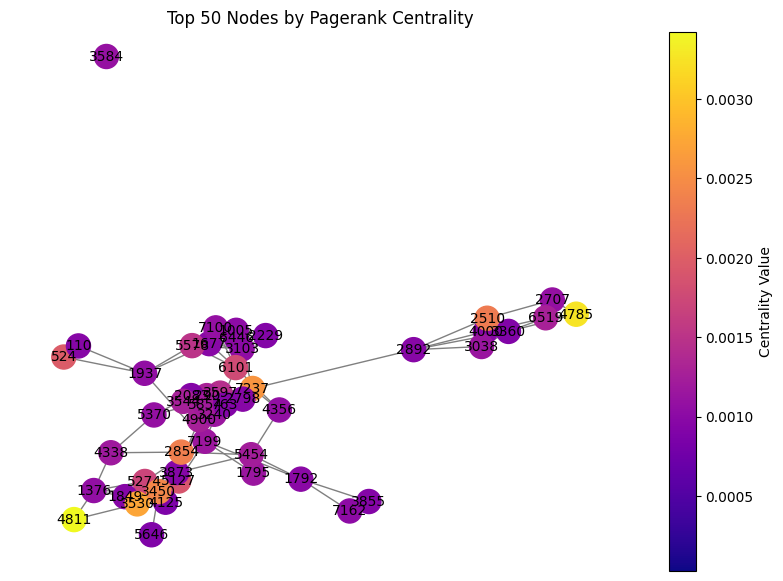

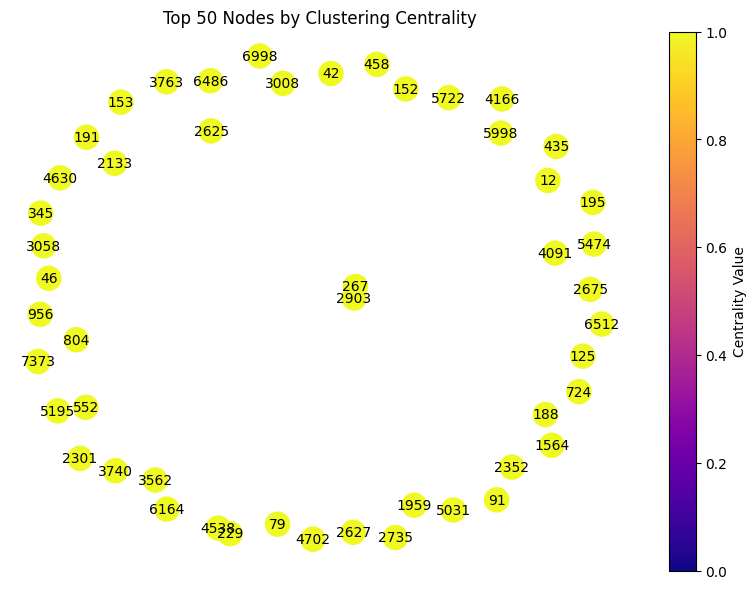

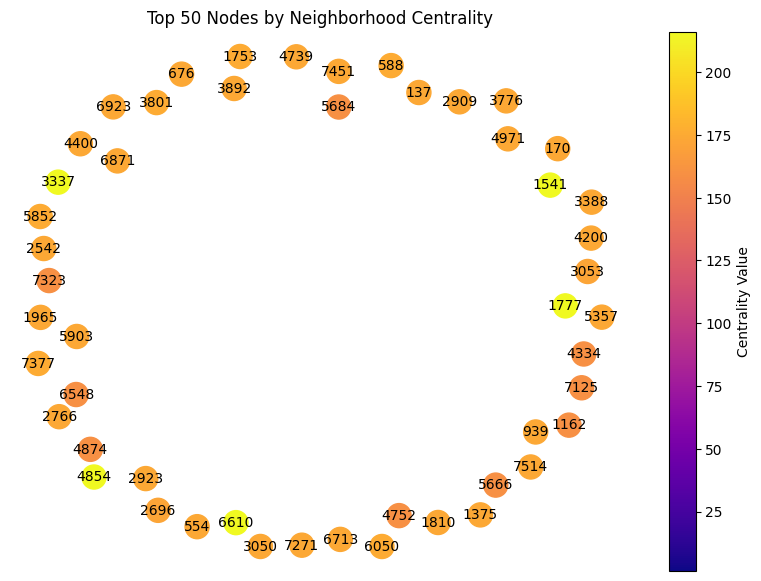

In [6]:
# Select centrality type for visualization
chosen_centralities = ["degree", "eigenvector", "katz", "pagerank", "clustering", "neighborhood"]

for chosen_centrality in chosen_centralities:
    subgraph, subgraph_centrality_values = extract_top_subgraph(lastfm_graph, lastfm_centralities, chosen_centrality)
    visualize_graph(subgraph, subgraph_centrality_values, title=f"Top 50 Nodes by {chosen_centrality.capitalize()} Centrality")


# 3- Community detection

## 3.1- 8-clique community

8-clique communautés calculées
Nombre de 8-clique communautés : 10


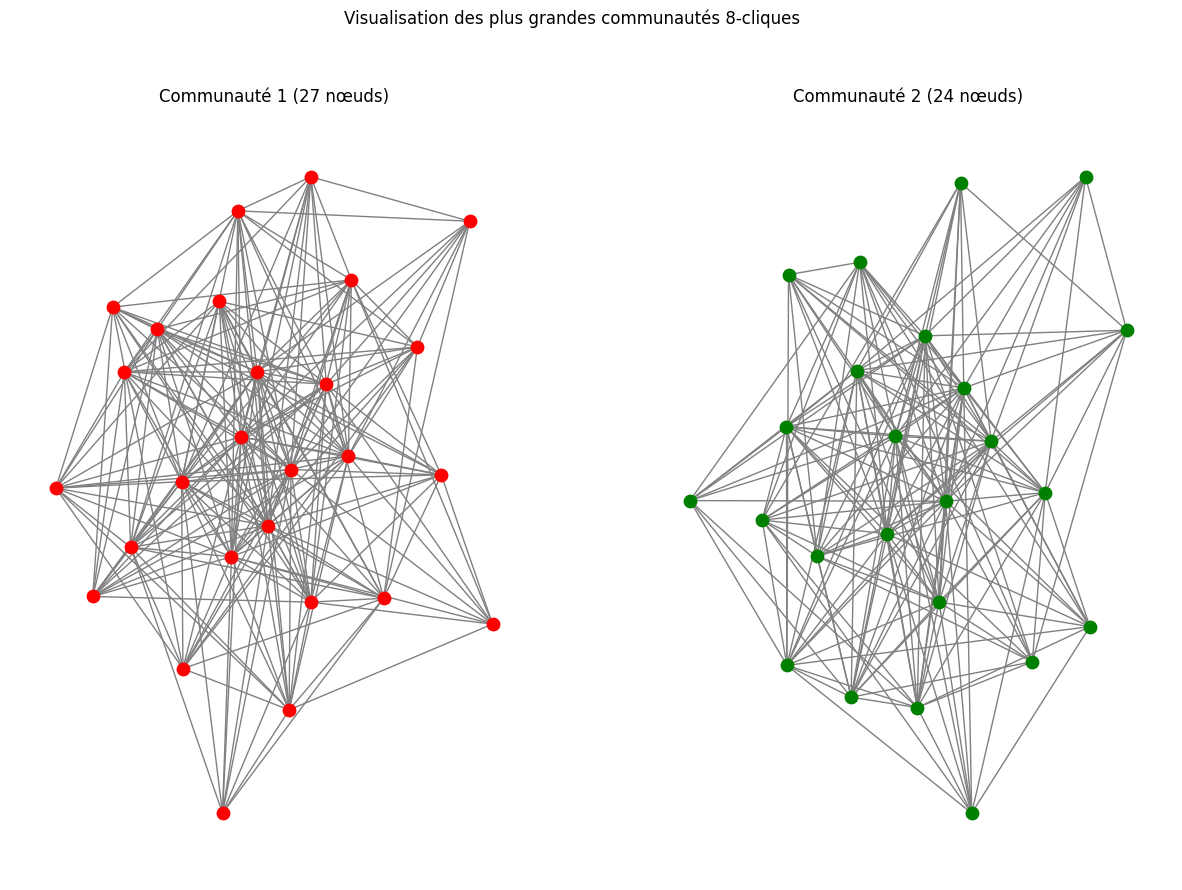

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

# Calcul des communautés 8-cliques
communities = sorted(list(nx.community.k_clique_communities(deezer_graph, 8)), key=len, reverse=True)
print("8-clique communautés calculées")
print(f"Nombre de 8-clique communautés : {len(communities)}")

# Sélectionner les k plus grandes communautés à afficher
k = min(2, len(communities))
communities = communities[:k]

colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y']) 

plt.figure(figsize=(15, 10))

for i, (community, color) in enumerate(zip(communities, colors), start=1):
    
    subgraph = deezer_graph.subgraph(community)
    pos = nx.spring_layout(subgraph, seed=42)
    
    # Dessiner le sous-graphe
    plt.subplot(1, k, i)
    nx.draw(subgraph, pos, node_color=color, edge_color='gray', with_labels=False, node_size=80)
    plt.title(f"Communauté {i} ({len(community)} nœuds)")

plt.suptitle("Visualisation des plus grandes communautés 8-cliques")
plt.show()



## 3.2- Louvain communities

Nombre de communautés de Louvain trouvées :  83


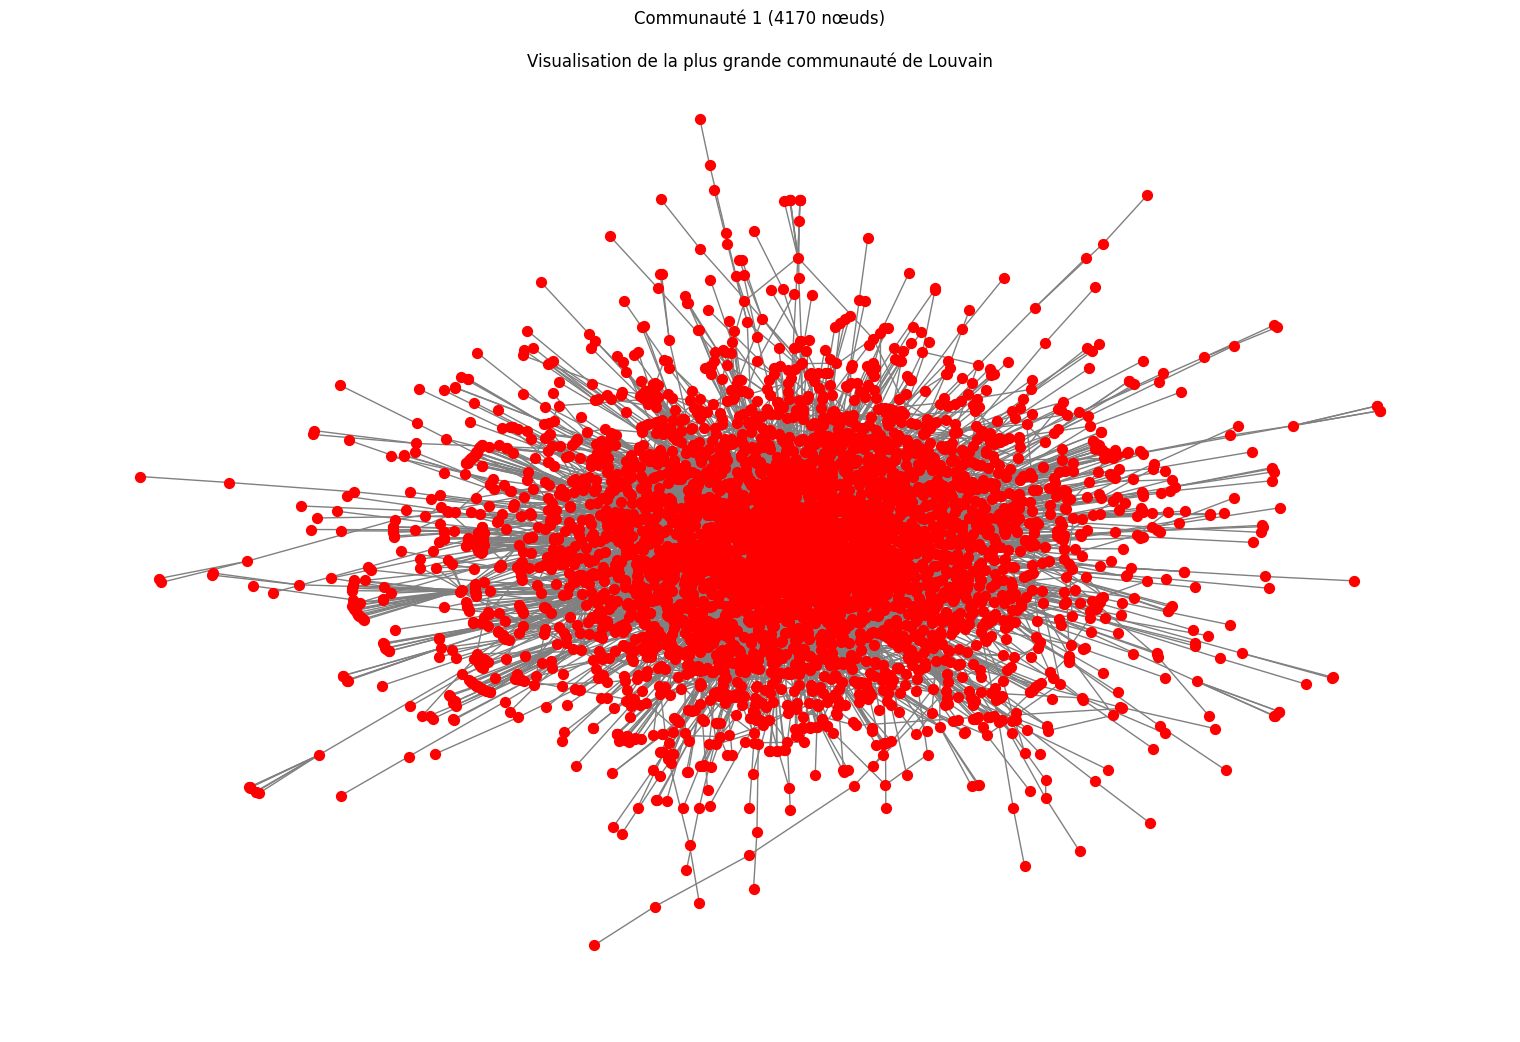

In [8]:
communities = sorted(list(nx.community.louvain_communities(deezer_graph)), key=len, reverse=True)
print("Nombre de communautés de Louvain trouvées : ", len(communities))

# Sélectionner les k plus grandes communautés à afficher
k = min(1, len(communities))
communities = communities[:k]

colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y']) 

plt.figure(figsize=(15, 10))

for i, (community, color) in enumerate(zip(communities, colors), start=1):
    subgraph = deezer_graph.subgraph(community)
    pos = nx.spring_layout(subgraph)
    
    # Dessiner le sous-graphe
    nx.draw(subgraph, pos, node_color=color, edge_color='gray', with_labels=False, node_size=50)
    plt.title(f"Communauté {i} ({len(community)} nœuds)")

plt.suptitle("Visualisation de la plus grande communauté de Louvain")
plt.show()


# 4- Embeddings

In [2]:
import numpy as np

used_graph = deezer_graph

percent_nodes = 0.01 # For faster execution
# percent_nodes = 1

if percent_nodes != 1 :
    n_nodes = int(used_graph.number_of_nodes() * percent_nodes)
    print(f"Selected nodes: {n_nodes} ({percent_nodes*100:.0f}%)")

    # Random walk sampling
    def random_walk_sampling(graph, start_node, walk_len, damping_factor=0.15):
        visited = {start_node}
        current_node = start_node
        for _ in range(walk_len):
            neighbors = list(graph.neighbors(current_node))
            if np.random.random()>damping_factor and neighbors:
                current_node = np.random.choice(neighbors)
                visited.add(current_node)
            else :
                current_node = np.random.choice(graph.nodes)
        return(visited)

    random_nodes = random_walk_sampling(used_graph,start_node=np.random.choice(used_graph.nodes),walk_len=n_nodes)
    used_graph = used_graph.subgraph(random_nodes)

print(used_graph)

Selected nodes: 282 (1%)
Graph with 192 nodes and 193 edges


## 4.1- Node2Vec embedding

In [3]:
# Node2vec embedding
from collections import defaultdict
import networkx as nx
import numpy as np
import random
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

class Node2vec:
    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 10,
                num_walks: int = 20, p: float = 1, q: float = 1, window_size: int = 5,
                min_count: int = 1, workers: int = 1, epochs: int = 10, quiet: bool = False):
        
        self.graph = graph
        self.dimensions =  dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.quiet = quiet

        self.p_graph = defaultdict(lambda: {'probabilities': {}})

        self._preprocess_modified_probs()
        if not self.quiet:
            print("Preprocessing des probabilités modifiées terminés.")
        self.walks = self._random_walk()
        if not self.quiet:
            print("Random walks calculées.")

        self.window_size = window_size
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs

        print("Entrainment du modèle Word2Vec pour calculer l'embedding.")
        self._train()
        print("Modèle entrainé.")


    def _preprocess_modified_probs(self):
        for origin_node in self.graph.nodes():

            for current_node in self.graph.neighbors(origin_node):
                unnormalized_probs = []

                for next_node in self.graph.neighbors(current_node):
                    if next_node == origin_node:
                        modified_prob = 1 / self.p
                    elif next_node in self.graph.neighbors(origin_node):
                        modified_prob = 1
                    else:
                        modified_prob = 1 / self.q

                    unnormalized_probs.append(modified_prob)

                # Normalisation
                if unnormalized_probs:
                    Z = abs(sum(unnormalized_probs))
                    normalized_probs = np.array([prob / Z for prob in unnormalized_probs])
                    self.p_graph[current_node]['probabilities'][origin_node] = normalized_probs

    def _random_walk(self) -> list:

        def _alias_setup(probs):

            N = len(probs)
            scaled_probs = [p * N for p in probs]
            prob = [0]*N
            alias = np.zeros(N, dtype=int) 

            small = []
            large = []

            for i, sp in enumerate(scaled_probs):
                if sp < 1: 
                    small.append(i)
                else:
                    large.append(i)

            while small and large:
                small_idx = small.pop()
                large_idx = large.pop()

                prob[small_idx] = scaled_probs[small_idx]
                alias[small_idx] = large_idx
                scaled_probs[large_idx] += (scaled_probs[small_idx] - 1)

                if scaled_probs[large_idx] < 1:
                    small.append(large_idx)
                else:
                    large.append(large_idx)

            return prob, alias

        def _choose_next(prob, alias):
            N = len(prob)
            i = np.random.randint(N)
            return i if np.random.rand() < prob[i] else alias[i]

        def _next_neighbor(current_node, origin_node, p_graph):
            neighbors = list(self.graph.neighbors(current_node))
            if not neighbors:
                return current_node
            
            prob = p_graph[current_node]['probabilities'][origin_node]
            prob, alias = _alias_setup(prob)

            next = _choose_next(prob, alias)
            return neighbors[next]
        
        def _compute_first_travel(node, p_graph):
            neighbors = list(self.graph.neighbors(node))
            return random.choice(neighbors) if neighbors else node

        walks = []
        for iter in range(self.num_walks):

            shuffled_nodes = list(self.graph.nodes())
            random.shuffle(shuffled_nodes)

            for node in shuffled_nodes:
                walk = [node]
                walk.append(_compute_first_travel(node, self.p_graph))
                for j in range(self.walk_length-1):
                    current_node, origin_node = walk[-1], walk[-2]
                    next = _next_neighbor(current_node, origin_node, self.p_graph)
                    walk.append(next)
                walks.append(walk)
        return walks
    
    def _train(self):
        walks_str = [[str(node) for node in walk] for walk in self.walks]
        self.model = Word2Vec(
            sentences=walks_str,
            vector_size=self.dimensions,
            window=self.window_size,
            min_count=self.min_count,
            sg=1,
            workers=self.workers,
            epochs=self.epochs
        )

    def get_embedding(self, node):
        return self.model.wv[str(node)] if str(node) in self.model.wv else None
    
    def cosine_similarity(self, node1, node2):
        emb1 = self.get_embedding(node1)
        emb2 = self.get_embedding(node2)
        
        if emb1 is None or emb2 is None:
            return None

        return 1 - cosine(emb1, emb2)


In [4]:
import node2vec as n2v

# Embedding Node2vec ci-dessus
node2vec_embedding = Node2vec(used_graph, p=0.2, q=1.2, workers=4, epochs=20)
print("Premier embedding calculé.")

# Embedding Node2vec de https://github.com/eliorc
node2vec_lib = n2v.node2vec.Node2Vec(used_graph, p=0.2, q=1.2, workers=4)
node2vec_model_lib =  node2vec_lib.fit(window=5, min_count=1)
print("Second embedding calculé.")

Preprocessing des probabilités modifiées terminés.
Random walks calculées.
Entrainment du modèle Word2Vec pour calculer l'embedding.
Modèle entrainé.
Premier embedding calculé.


Computing transition probabilities:   0%|          | 0/192 [00:00<?, ?it/s]

Second embedding calculé.


## 4.2- Spectral embedding

In [5]:
import numpy as np
import networkx as nx 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score 
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

A = nx.adjacency_matrix(used_graph).toarray()
D = np.diag(A.sum(axis=1)) 

# Pour éviter une division par 0
epsilon = 1e-6
D_inv_sqrt = np.diag(1.0 / np.sqrt(D.diagonal() + epsilon))
I = np.identity(len(D))

# Laplacian normalisé
L = I - D_inv_sqrt @ A @ D_inv_sqrt

# Laplacian
# L = D - A

# Valeurs et vecteurs propres
vals, vecs = np.linalg.eig(L)

tolerance = 1e-14
vals = np.real(vals)
vals[np.abs(vals) < tolerance] = 0
vecs = np.real(vecs)
vecs[np.abs(vecs) < tolerance] = 0

vals[:5]

array([1.70710625, 1.99193523, 1.96448119, 1.93027952, 1.94294279])

K-Means clustering
Explored range [2,28]


Calcul des embeddings et du silhouette scores: 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]


Optimal number of clusters from silhouette score: 2 (score: 0.8598)


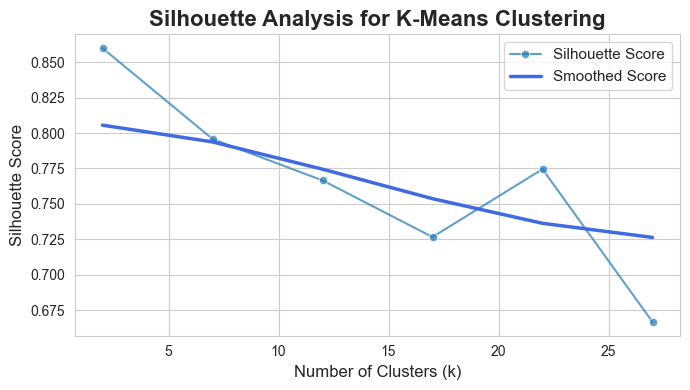

In [6]:
def k_smallest_eigvals(k, vals):
    nonzero_vals = [(i, val) for i, val in enumerate(vals) if val > 0]
    sorted_vals = sorted(nonzero_vals, key=lambda x: x[1])
    return sorted_vals[:k]

def get_U(k,vals,vecs):
    k_eigvals = k_smallest_eigvals(k,vals)
    k_eigvecs = [vecs[:,i] for (i,_) in k_eigvals]
    return(np.array(k_eigvecs).T)

# K-Means clustering avec analyse du silhouette score
print("K-Means clustering")
scores = []
explored_range = np.arange(n_nodes//100, n_nodes//10, 5)
print(f"Explored range [{n_nodes//100},{n_nodes//10}]")

for k in tqdm(explored_range, desc="Calcul des embeddings et du silhouette scores"):
    embeddings = get_U(k, vals, vecs)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    scores.append(score)

# Optimal k (maximum du silhouette score)
optimal_k = explored_range[np.argmax(scores)]
max_score = max(scores)
print(f"Optimal number of clusters from silhouette score: {optimal_k} (score: {max_score:.4f})")
laplacian_embedding = get_U(optimal_k, vals, vecs)

# Smoothing
scores_smooth = gaussian_filter1d(scores, sigma=2)

plt.figure(figsize=(7, 4))
sns.set_style("whitegrid")
sns.lineplot(x=explored_range, y=scores, marker='o', label='Silhouette Score', alpha=0.7)
sns.lineplot(x=explored_range, y=scores_smooth, linewidth=2.5, label='Smoothed Score', color='royalblue')

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for K-Means Clustering', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

Exercice 2 : D'après la décroissance de silhouette, à mesure qu'on augmente le nombre de clusters, on obtient des clusters moins pertinents.

## 4.3 Embeddings comparaison

The following assessment is derived from the following paper: "Systematic comparison of graph embedding methods in practical tasks". As suggested in the paper, it will take into account mapping accuracy, greedy routing, and link prediction.

In [103]:
class EmbeddingWrapper:
    def __init__(self,embedding, node_to_i, is_node2vec=False):
        self.embedding = embedding
        self.is_node2vec = is_node2vec
        self.node_to_i = node_to_i
        self.i_to_node = {i:node for node,i in node_to_i.items()}
    
    def get_embedding(self,node):
        if self.is_node2vec:
            return(self.embedding.get_embedding(node))
        else :
            return(self.embedding[self.node_to_i[node]])

node2vec_embedding_wrapper = EmbeddingWrapper(node2vec_embedding,{node:i for i,node in enumerate(used_graph.nodes())},True)
laplacian_embedding_wrapper = EmbeddingWrapper(laplacian_embedding,{node:i for i,node in enumerate(used_graph.nodes())})

### 4.3.1 Mapping accuracy

In [105]:
from sklearn.neighbors import NearestNeighbors

def mapping_accuracy(embedding_wrapper):
    embedding = [embedding_wrapper.get_embedding(node) for node in used_graph.nodes()]
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)

    correct_predictions = 0
    total_predictions = 0

    for node in used_graph.nodes():
        actual_neighbors = list(used_graph.neighbors(node))
        predicted_neighbors = [embedding_wrapper.i_to_node[i] for i in indices[embedding_wrapper.node_to_i[node]]]

        correct_predictions += len(set(actual_neighbors).intersection(predicted_neighbors))
        total_predictions += 1 # because knn with k=2, so max found 1 neighbor

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

accuracy_node2vec = mapping_accuracy(node2vec_embedding_wrapper)
accuracy_laplacian = mapping_accuracy(laplacian_embedding_wrapper)

print(f"Node2vec Mapping Accuracy: {accuracy_node2vec}")
print(f"Laplacian Eigenmaps Mapping Accuracy: {accuracy_laplacian}")

Node2vec Mapping Accuracy: 0.890625
Laplacian Eigenmaps Mapping Accuracy: 0.4427083333333333


### 4.3.2 Greedy routing

In [ ]:
def greedy_routing(embedding_wrapper, source, target):
    """
    Takes steps from euclidiean distance in embedding space until target is found or next_step is not a neighbor of current_node.
    """
    embedding = [embedding_wrapper.get_embedding(node) for node in used_graph.nodes()]
    visited = {source}
    current = source
    steps = 0
    no_new = 0
    while current != target:
        distances = np.linalg.norm(embedding - embedding[embedding_wrapper.node_to_i[current]], axis=1)
        distances = np.delete(distances,embedding_wrapper.node_to_i[current])
        next_node = np.argmin(distances)
        next_node = embedding_wrapper.i_to_node[next_node]
        if (not next_node in used_graph.neighbors(current)) or no_new==10:
            return False, steps  # Failure if no direct edge
        current = next_node
        steps += 1

        if current in visited:
            no_new += 1
        else :
            no_new = 0
        visited.add(current)
    return True, steps

def random_k_away_neighbor(k,source,graph):
    for _ in range(k):
        neigbors = list(graph.neighbors(source))
        if neigbors:
            source = random.choice(neigbors)
        else :
            source = random.choice(list(used_graph.nodes()))
    return(source)

steps_node2vec, steps_laplacian = 0, 0
for _ in range(1000):
    source = random.choice(list(used_graph.nodes()))
    target = random_k_away_neighbor(5,source,used_graph)
    success_node2vec, current_steps_node2vec = greedy_routing(node2vec_embedding_wrapper, source, target)
    success_laplacian, current_steps_laplacian = greedy_routing(laplacian_embedding_wrapper, source, target)
    steps_node2vec += current_steps_node2vec
    steps_laplacian += current_steps_laplacian

print(f"Node2vec Greedy Routing completed {steps_node2vec} correct steps.")
print(f"Laplacian Eigenmaps Greedy Routing completed {steps_laplacian} correct steps.")

Node2vec Greedy Routing completed 514 correct steps.
Laplacian Eigenmaps Greedy Routing completed 220 correct steps.


### 4.3.3 Link prediction

In [130]:
from sklearn.metrics import roc_auc_score

def link_prediction(embedding_wrapper, adjacency_matrix):
    embedding = [embedding_wrapper.get_embedding(node) for node in used_graph.nodes()]
    # Pairs de neouds voisins (positive) ou non (negative)
    positive_samples = []
    negative_samples = []

    for i in range(len(adjacency_matrix)):
        for j in range(i + 1, len(adjacency_matrix)):
            if embedding_wrapper.i_to_node[j] in adjacency_matrix[embedding_wrapper.i_to_node[i]]:
                positive_samples.append((i, j))
            else:
                negative_samples.append((i, j))

    # Calcul des scores
    positive_scores = [np.dot(embedding[i], embedding[j]) for i, j in positive_samples]
    negative_scores = [np.dot(embedding[i], embedding[j]) for i, j in negative_samples]

    # Comparaison grâce au ROC AUC score
    scores = positive_scores + negative_scores
    labels = [1] * len(positive_scores) + [0] * len(negative_scores)
    auc = roc_auc_score(labels, scores)
    return auc

auc_node2vec = link_prediction(node2vec_embedding_wrapper, used_graph.adj)
auc_laplacian = link_prediction(laplacian_embedding_wrapper, used_graph.adj)

print(f"Node2vec Link Prediction AUC: {auc_node2vec}")
print(f"Laplacian Eigenmaps Link Prediction AUC: {auc_laplacian}")


Node2vec Link Prediction AUC: 0.9957445155770266
Laplacian Eigenmaps Link Prediction AUC: 0.7854048964487367


Node2Vec sort grand vainqueur de ces comparaisons.